In [1]:
import numpy as np 
import pandas as pd 
import warnings
import sdv
import os
from sklearn.impute import KNNImputer
from numpy import isnan
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
print(sdv.__version__)

1.5.0


In [3]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

In [4]:
directory = 'uploads'
# List all files in the directory
file_list = os.listdir(directory)
# Iterate through each file in the directory
for filename in file_list:
    # Construct the full file path
    file_path = os.path.join(directory, filename)

    try:
        # Check if the file is a CSV file (you can adjust this condition for other file types)
        if filename.endswith('.csv'):
            # Read the CSV file using Pandas
            df = pd.read_csv(file_path)
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")
df2=df.dropna(how='all') #to drop rows that have all values as NaN.
df2

,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,CUSTOMER_NAME,ADDRESS_LINE1,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
0,A00003822,PLC00008468,6/23/2015,5/16/2020,5/21/2020,Health,157.13,9000.0,Christopher Demarest,7701 West Saint John Road,...,A,Major Loss,Police,0.0,1.0,GA,Savannah,4.0,AGENT00413,VNDR00556
1,A00008149,PLC00009594,4/21/2018,5/13/2020,5/18/2020,Property,141.71,26000.0,Ricardo Gatlin,8595 West 81st Drive,...,A,Total Loss,Ambulance,1.0,0.0,AL,Montgomery,0.0,AGENT00769,VNDR00592
2,A00003172,PLC00007969,10/3/2019,5/21/2020,5/26/2020,Property,157.24,13000.0,Lashawn Engles,637 Britannia Drive,...,A,Total Loss,Police,0.0,1.0,CO,Grand Junction,19.0,AGENT00883,VNDR00031
3,A00007572,PLC00009292,11/29/2016,5/14/2020,5/19/2020,Health,172.87,16000.0,Steven Bassett,2803 River Drive,...,A,Minor Loss,Ambulance,0.0,0.0,GA,Savannah,12.0,AGENT00278,VNDR00075
4,A00008173,PLC00000204,12/26/2011,5/17/2020,5/22/2020,Travel,88.53,3000.0,Jason Rodriguez,7573 National Drive,...,A,Major Loss,Police,0.0,1.0,TN,Nashville,18.0,AGENT00636,VNDR00472
5,A00003571,PLC00007244,12/28/2012,5/20/2020,5/25/2020,Life,87.02,63000.0,Terrance Han,5275 North 59th Avenue,...,A,Major Loss,Ambulance,0.0,1.0,AZ,Glendale,0.0,AGENT00402,NaN
6,A00007245,PLC00002796,10/26/2012,5/13/2020,5/18/2020,Health,197.23,3000.0,Dennis Johnson,5119 Marla Drive,...,A,Major Loss,Police,1.0,1.0,CT,Manchester,10.0,AGENT00322,VNDR00150
7,A00004301,PLC00002925,12/30/2018,5/14/2020,5/19/2020,Motor,83.77,8000.0,Maryalice Martinez,6 Little Country Place,...,A,Total Loss,Police,0.0,1.0,FL,Panama City Beach,10.0,AGENT00152,VNDR00326
8,A00004671,PLC00006886,6/27/2019,5/21/2020,5/26/2020,Motor,82.14,5000.0,Nicholas Hamilton,642 South 2nd Street,...,A,Major Loss,Police,0.0,1.0,AZ,Glendale,22.0,AGENT00450,VNDR00437
9,A00002020,PLC00007657,12/19/2015,5/15/2020,5/20/2020,Travel,71.29,4000.0,Nicholas Honokaupu,1914 Stratford Downs Drive,...,A,Major Loss,NaN,0.0,0.0,CA,San Leandro,4.0,AGENT00682,NaN


In [5]:
label_encoder = LabelEncoder()
label_mappings = {}

for col in df2.columns:
    if df2[col].dtype == 'object':
        df2[col] = df2[col].fillna('None')  # Filling NaN values with a string for label encoding to work
        df2[col] = label_encoder.fit_transform(df2[col])
        label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    if df2[col].dtype == 'datetime64[ns]':
        df2[col] = df2[col].astype('int64')

num_arr = df2.values

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputed_array = imputer.fit_transform(num_arr)

# Convert the NumPy array back to a DataFrame
df2_imputed = pd.DataFrame(imputed_array, columns=df2.columns)

# Inverse transforming the encoded columns back to their original categorical form
for col in df2_imputed.columns:
    if col in label_mappings:
        df2_imputed[col] = df2_imputed[col].map({v: k for k, v in label_mappings[col].items()})

# Converting the 'datetime64[ns]' columns back to their original form
for col in df2_imputed.columns:
    if df2_imputed[col].dtype == 'int64':
        df2_imputed[col] = pd.to_datetime(df2_imputed[col])

In [6]:
directory='outputs'
output_file_path = os.path.join(directory, 'transformed_data.csv') #this csv file contains the dataset after having removed the NaN values.
df2=df2_imputed
df2

,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,CUSTOMER_NAME,ADDRESS_LINE1,...,CLAIM_STATUS,INCIDENT_SEVERITY,AUTHORITY_CONTACTED,ANY_INJURY,POLICE_REPORT_AVAILABLE,INCIDENT_STATE,INCIDENT_CITY,INCIDENT_HOUR_OF_THE_DAY,AGENT_ID,VENDOR_ID
0,A00003822,PLC00008468,6/23/2015,5/16/2020,5/21/2020,Health,157.13,9000.0,Christopher Demarest,7701 West Saint John Road,...,A,Major Loss,Police,0.0,1.0,GA,Savannah,4.0,AGENT00413,VNDR00556
1,A00008149,PLC00009594,4/21/2018,5/13/2020,5/18/2020,Property,141.71,26000.0,Ricardo Gatlin,8595 West 81st Drive,...,A,Total Loss,Ambulance,1.0,0.0,AL,Montgomery,0.0,AGENT00769,VNDR00592
2,A00003172,PLC00007969,10/3/2019,5/21/2020,5/26/2020,Property,157.24,13000.0,Lashawn Engles,637 Britannia Drive,...,A,Total Loss,Police,0.0,1.0,CO,Grand Junction,19.0,AGENT00883,VNDR00031
3,A00007572,PLC00009292,11/29/2016,5/14/2020,5/19/2020,Health,172.87,16000.0,Steven Bassett,2803 River Drive,...,A,Minor Loss,Ambulance,0.0,0.0,GA,Savannah,12.0,AGENT00278,VNDR00075
4,A00008173,PLC00000204,12/26/2011,5/17/2020,5/22/2020,Travel,88.53,3000.0,Jason Rodriguez,7573 National Drive,...,A,Major Loss,Police,0.0,1.0,TN,Nashville,18.0,AGENT00636,VNDR00472
5,A00003571,PLC00007244,12/28/2012,5/20/2020,5/25/2020,Life,87.02,63000.0,Terrance Han,5275 North 59th Avenue,...,A,Major Loss,Ambulance,0.0,1.0,AZ,Glendale,0.0,AGENT00402,None
6,A00007245,PLC00002796,10/26/2012,5/13/2020,5/18/2020,Health,197.23,3000.0,Dennis Johnson,5119 Marla Drive,...,A,Major Loss,Police,1.0,1.0,CT,Manchester,10.0,AGENT00322,VNDR00150
7,A00004301,PLC00002925,12/30/2018,5/14/2020,5/19/2020,Motor,83.77,8000.0,Maryalice Martinez,6 Little Country Place,...,A,Total Loss,Police,0.0,1.0,FL,Panama City Beach,10.0,AGENT00152,VNDR00326
8,A00004671,PLC00006886,6/27/2019,5/21/2020,5/26/2020,Motor,82.14,5000.0,Nicholas Hamilton,642 South 2nd Street,...,A,Major Loss,Police,0.0,1.0,AZ,Glendale,22.0,AGENT00450,VNDR00437
9,A00002020,PLC00007657,12/19/2015,5/15/2020,5/20/2020,Travel,71.29,4000.0,Nicholas Honokaupu,1914 Stratford Downs Drive,...,A,Major Loss,None,0.0,0.0,CA,San Leandro,4.0,AGENT00682,None


In [7]:
metadata = SingleTableMetadata()

In [8]:
metadata.detect_from_dataframe(data=df2)

In [9]:
synthesizer1 = CTGANSynthesizer(
    
    metadata, # required
    enforce_rounding=True,
    enforce_min_max_values=True,
    epochs=500,
    verbose=True
)

In [10]:
metadata = synthesizer1.get_metadata()
metadata

{
    "columns": {
        "CUSTOMER_ID": {
            "sdtype": "id"
        },
        "POLICY_NUMBER": {
            "sdtype": "unknown",
            "pii": true
        },
        "POLICY_EFF_DT": {
            "sdtype": "datetime",
            "datetime_format": "%m/%d/%Y"
        },
        "LOSS_DT": {
            "sdtype": "datetime",
            "datetime_format": "%m/%d/%Y"
        },
        "REPORT_DT": {
            "sdtype": "datetime",
            "datetime_format": "%m/%d/%Y"
        },
        "INSURANCE_TYPE": {
            "sdtype": "unknown",
            "pii": true
        },
        "PREMIUM_AMOUNT": {
            "sdtype": "numerical"
        },
        "CLAIM_AMOUNT": {
            "sdtype": "numerical"
        },
        "CUSTOMER_NAME": {
            "sdtype": "unknown",
            "pii": true
        },
        "ADDRESS_LINE1": {
            "sdtype": "unknown",
            "pii": true
        },
        "ADDRESS_LINE2": {
            "sdtype": "unknown",
 

In [11]:
python_dict = metadata.to_dict()
metadata.validate()
metadata.update_column(
column_name='CUSTOMER_ID', # to change the data type of metadata to id;
    sdtype='id',
    regex_format='A[0-9]{8}',
) 
# only metadata of id format can be set as primary key
metadata.set_primary_key(column_name='CUSTOMER_ID')
# update all metadata depending on type of change needed 
# The SDV models can use the Python Faker library for new data types. You can input any of the function names as sdtypes.
# For example, inputting the sdtype first_name will use this function to generate meaningful first names. 
metadata.update_column(
    column_name='ADDRESS_LINE1',
    sdtype='address',
    pii=True
)
metadata.update_column(
    column_name='ADDRESS_LINE2',
    sdtype='address',
    pii=True
)
metadata.update_column(
    column_name='CUSTOMER_NAME',
    sdtype='name',
    pii=True
)
metadata.update_column(
    column_name='ACCT_NUMBER',
    sdtype='bban',
    pii=True
)
metadata.update_column(
    column_name='ANY_INJURY',
    sdtype='categorical',
)
metadata.update_column(
    column_name='POLICE_REPORT_AVAILABLE',
    sdtype='categorical',
)
metadata.update_column(
    column_name='POSTAL_CODE',
    sdtype='postcode',
)
metadata.update_column(
    column_name='INCIDENT_HOUR_OF_THE_DAY',
    sdtype='numerical',
    computer_representation = "UInt8",
)
metadata.update_column(
    column_name='CITY',
    sdtype='city',
    pii=True
)

In [12]:
metadata

{
    "columns": {
        "CUSTOMER_ID": {
            "sdtype": "id",
            "regex_format": "A[0-9]{8}"
        },
        "POLICY_NUMBER": {
            "sdtype": "unknown",
            "pii": true
        },
        "POLICY_EFF_DT": {
            "sdtype": "datetime",
            "datetime_format": "%m/%d/%Y"
        },
        "LOSS_DT": {
            "sdtype": "datetime",
            "datetime_format": "%m/%d/%Y"
        },
        "REPORT_DT": {
            "sdtype": "datetime",
            "datetime_format": "%m/%d/%Y"
        },
        "INSURANCE_TYPE": {
            "sdtype": "unknown",
            "pii": true
        },
        "PREMIUM_AMOUNT": {
            "sdtype": "numerical"
        },
        "CLAIM_AMOUNT": {
            "sdtype": "numerical"
        },
        "CUSTOMER_NAME": {
            "sdtype": "name",
            "pii": true
        },
        "ADDRESS_LINE1": {
            "sdtype": "address",
            "pii": true
        },
        "ADDRESS_LINE2"

In [13]:
synthesizer1.get_constraints()

[]

In [14]:
#Auto assigning the transformers
synthesizer1.auto_assign_transformers(df2)
synthesizer1.get_transformers()

{'CUSTOMER_ID': RegexGenerator(regex_format='A[0-9]{8}', enforce_uniqueness=True),
 'POLICY_NUMBER': AnonymizedFaker(function_name='bothify', function_kwargs={'text': 'sdv-pii-?????', 'letters': '0123456789abcdefghijklmnopqrstuvwxyz'}),
 'POLICY_EFF_DT': UnixTimestampEncoder(datetime_format='%m/%d/%Y'),
 'LOSS_DT': UnixTimestampEncoder(datetime_format='%m/%d/%Y'),
 'REPORT_DT': UnixTimestampEncoder(datetime_format='%m/%d/%Y'),
 'INSURANCE_TYPE': AnonymizedFaker(function_name='bothify', function_kwargs={'text': 'sdv-pii-?????', 'letters': '0123456789abcdefghijklmnopqrstuvwxyz'}),
 'PREMIUM_AMOUNT': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'CLAIM_AMOUNT': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'CUSTOMER_NAME': AnonymizedFaker(provider_name='person', function_name='name'),
 'ADDRESS_LINE1': AnonymizedFaker(provider_name='address', function_name='address'),
 'ADDRESS_LINE2': AnonymizedFaker(provider_name='address', functio

In [15]:
#Adding transformers base on need for annonimity
#anonymizing the user personal data using Faker library functions
from rdt.transformers.pii import PseudoAnonymizedFaker 
from rdt.transformers.pii import AnonymizedFaker
synthesizer1.update_transformers(column_name_to_transformer={
    'ADDRESS_LINE1': AnonymizedFaker(provider_name='address', function_name='address'),
})
synthesizer1.update_transformers(column_name_to_transformer={
    'ADDRESS_LINE2': AnonymizedFaker(provider_name='address', function_name='address'),
})
synthesizer1.update_transformers(column_name_to_transformer={
    'CUSTOMER_NAME': AnonymizedFaker(provider_name='person', function_name='name'),
})
synthesizer1.update_transformers(column_name_to_transformer={
    'ACCT_NUMBER': AnonymizedFaker(provider_name='bank', function_name='bban'),
})
synthesizer1.update_transformers(column_name_to_transformer={
    'POSTAL_CODE': AnonymizedFaker(provider_name='address', function_name='postcode'),
})
synthesizer1.update_transformers(column_name_to_transformer={
    'CITY': AnonymizedFaker(provider_name='address', function_name='city'),
})
synthesizer1.update_transformers(column_name_to_transformer={
    'POLICY_NUMBER': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'INSURANCE_TYPE': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'SSN': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'ROUTING_NUMBER': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'CUSTOMER_EDUCATION_LEVEL': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'INCIDENT_STATE': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'INCIDENT_CITY': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'AGENT_ID': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'VENDOR_ID': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'STATE': None
})
synthesizer1.update_transformers(column_name_to_transformer={
    'AUTHORITY_CONTACTED': None
})
synthesizer1.get_transformers()


{'CUSTOMER_ID': RegexGenerator(regex_format='A[0-9]{8}', enforce_uniqueness=True),
 'POLICY_NUMBER': None,
 'POLICY_EFF_DT': UnixTimestampEncoder(datetime_format='%m/%d/%Y'),
 'LOSS_DT': UnixTimestampEncoder(datetime_format='%m/%d/%Y'),
 'REPORT_DT': UnixTimestampEncoder(datetime_format='%m/%d/%Y'),
 'INSURANCE_TYPE': None,
 'PREMIUM_AMOUNT': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'CLAIM_AMOUNT': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 'CUSTOMER_NAME': AnonymizedFaker(provider_name='person', function_name='name'),
 'ADDRESS_LINE1': AnonymizedFaker(provider_name='address', function_name='address'),
 'ADDRESS_LINE2': AnonymizedFaker(provider_name='address', function_name='address'),
 'CITY': AnonymizedFaker(provider_name='address', function_name='city'),
 'STATE': None,
 'POSTAL_CODE': AnonymizedFaker(provider_name='address', function_name='postcode'),
 'SSN': None,
 'MARITAL_STATUS': None,
 'AGE': FloatFormatter(learn_

In [16]:
synthesizer1.fit(df2)

Gen. (0.32) | Discrim. (-1.32): 100%|██████████| 500/500 [01:06<00:00,  7.47it/s]


In [17]:
synthesizer1.save(
    filepath='ctgan_synthesizer1.pkl'
)

In [18]:
synthesizer1.load(
    filepath='ctgan_synthesizer1.pkl'
)

In [19]:
synthetic1_data = synthesizer1.sample(num_rows=1000)

# save the data as a CSV
# synthetic_data.to_csv('synthetic_data.csv', index=False)

In [20]:
#synthetic1_data.round() #this round out all the float values in the dataframe
#trial=pd.DataFrame(synthetic1_data) use this command to copy the values into trial and then continue manipulation

In [21]:
synthetic1_data=synthetic1_data.astype({"CLAIM_AMOUNT":"int","AGE":"int","TENURE":"int","NO_OF_FAMILY_MEMBERS":"int","ROUTING_NUMBER":"int","INCIDENT_HOUR_OF_THE_DAY":"int"})

In [22]:
directory='outputs'
output_file_path = os.path.join(directory, 'synthetic1_data.csv')
# Save the DataFrame as a CSV file in the output directory
synthetic1_data.to_csv(output_file_path, index=False)


In [23]:
#Quality Evaluation
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=df2,
    synthetic_data=synthetic1_data,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 630/630 [00:01<00:00, 433.01it/s]

Overall Quality Score: 76.2%

Properties:
- Column Shapes: 83.79%
- Column Pair Trends: 68.61%


In [24]:
#another round about way of doing things.
#Report Generation
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.reports.single_table import DiagnosticReport
report = QualityReport()
#dictonary input of the metadata is required for the report.generate because its subscriptable.
python_dict = metadata.to_dict()
report = DiagnosticReport()
report.generate(df2, synthetic1_data,python_dict)

Generating report ...
(3/3) Evaluating Synthesis: : 100%|██████████| 1/1 [00:09<00:00,  9.31s/it]

Diagnostic Results:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data

! More than 10% the synthetic data does not follow the min/max boundaries set by the real data


In [25]:
#Use this function to receive some diagnostic results about your synthetic data.
from sdv.evaluation.single_table import run_diagnostic
diagnostic_report = run_diagnostic(
    real_data=df2,
    synthetic_data=synthetic1_data,
    metadata=metadata)

Generating report ...
(3/3) Evaluating Synthesis: : 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]

Diagnostic Results:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data

! More than 10% the synthetic data does not follow the min/max boundaries set by the real data


In [26]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df2,
    synthetic_data=synthetic1_data,
    metadata=metadata,
    column_name='PREMIUM_AMOUNT'
)
fig.show()

In [27]:
quality_report.get_visualization(property_name='Column Shapes')

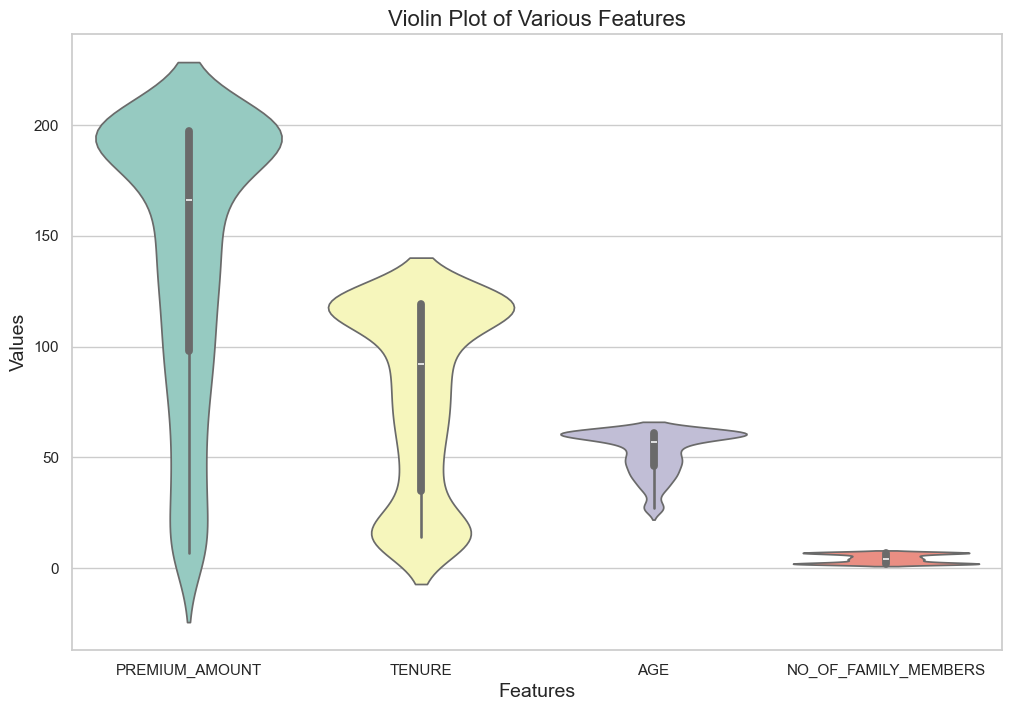

In [34]:
# Create a violin plot for the specified columns
columns_to_plot = [ 'PREMIUM_AMOUNT', 'TENURE', 'AGE', 'NO_OF_FAMILY_MEMBERS']

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a violin plot
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.violinplot(data=synthetic1_data[columns_to_plot], palette="Set3")

# Set the title and labels
plt.title("Violin Plot of Various Features", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Values", fontsize=14)

# Show the plot
plt.show()


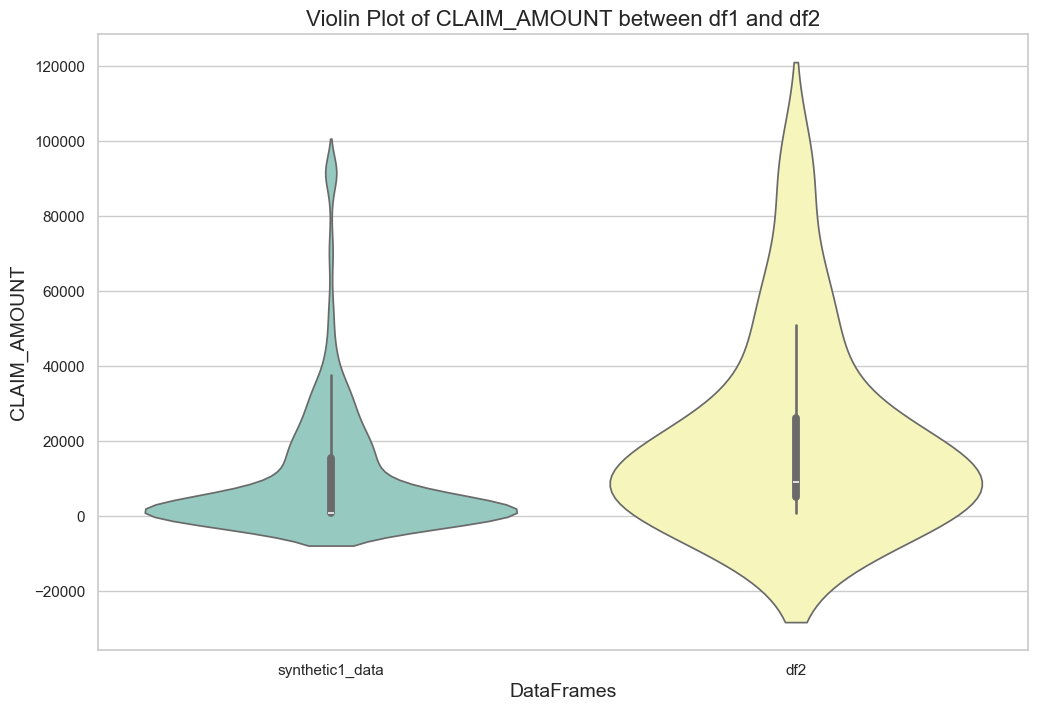

In [33]:
# Column to compare
column_to_compare = 'CLAIM_AMOUNT'

# Combine the data from both DataFrames
combined_data = pd.concat([synthetic1_data[column_to_compare], df2[column_to_compare]], axis=1)
combined_data.columns = ['synthetic1_data', 'df2']

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a violin plot
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.violinplot(data=combined_data, palette="Set3")

# Set the title and labels
plt.title(f"Violin Plot of {column_to_compare} between df1 and df2", fontsize=16)
plt.xlabel("DataFrames", fontsize=14)
plt.ylabel(column_to_compare, fontsize=14)

# Show the plot
plt.show()
